In [16]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt

In [17]:
# Load MNIST data
def load_mnist_data():
    train_images = idx2numpy.convert_from_file('train-images-idx3-ubyte')
    train_labels = idx2numpy.convert_from_file('train-labels-idx1-ubyte')
    test_images = idx2numpy.convert_from_file('t10k-images-idx3-ubyte')
    test_labels = idx2numpy.convert_from_file('t10k-labels-idx1-ubyte')
    return (train_images.reshape(train_images.shape[0], -1) / 255, train_labels), \
           (test_images.reshape(test_images.shape[0], -1) / 255, test_labels)


(train_images, train_labels), (test_images, test_labels) = load_mnist_data()

In [18]:
# Activation functions
def ReLU(res):
    return np.maximum(res, 0)

def ReLU_derivative(x):
    return np.where(x > 0, 1, 0)

def softmax(res):
    e_x = np.exp(res - np.max(res, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

# Initialize parameters
def init_params(size, std=1):
    return np.random.randn(*size) * std

# One hot encoding
def one_hot(y):
    one_h = np.zeros((y.size, y.max() + 1))
    one_h[np.arange(y.size), y] = 1
    return one_h

# Create a random batch of data
def create_batch(data, data_y, batch_size):
    batch_indices = np.random.choice(data[0].shape[0], batch_size, replace=False)
    xb, yb = data[0][batch_indices], data_y[batch_indices]
    return xb, yb

# Initialize parameters
def create_params():
    params = {}
    params['w1'] = init_params((28*28, 30))
    params['b1'] = init_params((30,))
    params['w2'] = init_params((30,10))
    params['b2'] = init_params((10,))
    params['w3'] = init_params((10,10))
    params['b3'] = init_params((10,))
    return params

# Forward pass
def forward(xb, params):
    Z1 = xb @ params['w1'] + params['b1']
    A1 = ReLU(Z1)
    Z2 = A1 @ params['w2'] + params['b2']
    A2 = ReLU(Z2)
    Z3 = A2 @ params['w3'] + params['b3']
    A3 = softmax(Z3)
    return A3, A2, A1

# Cross-entropy loss with L2 regularization
def cross_entropy_loss_with_l2(res, y, params, l2_penalty):
    one_hot_y = one_hot(y)
    cross_entropy = -np.sum(one_hot_y * np.log(res + 1e-6)) / len(y)
    # Add L2 regularization term
    l2_reg = 0.5 * l2_penalty * (np.sum(np.square(params['w1'])) +
                                 np.sum(np.square(params['w2'])) +
                                 np.sum(np.square(params['w3'])))
    loss = cross_entropy + l2_reg
    return loss

# Backpropagation with L2 regularization
def back_prop_with_l2(xb, yb, res, params, l2_penalty, l2, l1):
    grads = {}
    m = xb.shape[0]
    # Backwards pass for third layer
    dloss_dy = res - one_hot(yb)  # Gradient of loss w.r.t. softmax
    grads['w3'] = 1 / m * (l2.T @ dloss_dy + l2_penalty * params['w3'])
    grads['b3'] = 1 / m * np.sum(dloss_dy, axis=0)

    # Backwards pass for second layer
    d_l2 = ReLU_derivative(l2) * (dloss_dy @ params['w3'].T)
    grads['w2'] = 1 / m * (l1.T @ d_l2 + l2_penalty * params['w2'])
    grads['b2'] = 1 / m * np.sum(d_l2, axis=0)

    # Backwards pass for first layer
    d_l1 = ReLU_derivative(l1) * (d_l2 @ params['w2'].T)
    grads['w1'] = 1 / m * (xb.T @ d_l1 + l2_penalty * params['w1'])
    grads['b1'] = 1 / m * np.sum(d_l1, axis=0)

    return grads


# Update parameters
def update_params(params, grads, lr):
    p = params
    for key in p.keys():
        p[key] -= lr * grads[key]
    return p

# Accuracy calculation
def accuracy(res, yb):
    return (np.argmax(res, axis=1) == yb).mean()

In [19]:
def train_with_metrics(data, data_y, test_data, test_data_y, epochs, batch_size=256, lr=0.1, l2_penalty=0.001, save_path=None):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    best_test_accuracy = 0.0
    best_params = None
    params = create_params()
    
    for ep in range(epochs + 1):
        for batch in range(int(data[0].shape[0] / batch_size) + 1):
            # Create a random batch of data
            xb, yb = create_batch(data, data_y, batch_size)
            res, l2, l1 = forward(xb, params)
            grads = back_prop_with_l2(xb, yb, res, params, l2_penalty, l2, l1)
            params = update_params(params, grads, lr)
        
        if ep % 50 == 0:
            # Calculate metrics for training set
            res_train, _, _ = forward(data[0], params)
            train_loss = cross_entropy_loss_with_l2(res_train, data_y, params, l2_penalty)
            train_accuracy = accuracy(res_train, data_y)
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            
            # Calculate metrics for test set
            res_test, _, _ = forward(test_data[0], params)
            test_loss = cross_entropy_loss_with_l2(res_test, test_data_y, params, l2_penalty)
            test_accuracy = accuracy(res_test, test_data_y)
            test_losses.append(test_loss)
            test_accuracies.append(test_accuracy)
            
            print(f"Epoch: {ep}/{epochs}")
            print(f"Training Loss: {train_loss}")
            print(f"Training Accuracy: {train_accuracy}")
            print(f"Test Loss: {test_loss}")
            print(f"Test Accuracy: {test_accuracy}")
            print("----------------------------------------")
            
            # Check if current test accuracy is better than the best seen so far
            if test_accuracy > best_test_accuracy:
                best_test_accuracy = test_accuracy
                best_params = params
                # Save the parameters of the best model if save_path is provided
                if save_path:
                    np.savez(save_path, **best_params)
                
    return train_losses, train_accuracies, test_losses, test_accuracies


In [24]:
# Training function with automatic saving of the best model based on test set performance
def train_with_best_model(data, data_y, test_data, test_data_y, epochs, batch_size=256, lr=0.1, l2_penalty=0.001, save_path=None):
    best_validation_accuracy = 0.0
    best_params = None
    params = create_params()
    
    for ep in range(epochs + 1):
        for batch in range(int(data[0].shape[0] / batch_size) + 1):
            # Create a random batch of data
            xb, yb = create_batch(data, data_y, batch_size)
            res, l2, l1 = forward(xb, params)
            grads = back_prop_with_l2(xb, yb, res, params, l2_penalty, l2, l1)
            params = update_params(params, grads, lr)
        
        if ep % 50 == 0:
            res_train, _, _ = forward(data[0], params)
            res_test, _, _ = forward(test_data[0], params)
            validation_accuracy = accuracy(res_test, test_data_y)
            
            print(f"Epoch: {ep}/{epochs}")
            print(f"Loss: {cross_entropy_loss_with_l2(res_train, data_y, params, l2_penalty)}")
            print(f"Training Accuracy: {accuracy(res_train, data_y)}")
            print(f"Validation Accuracy: {validation_accuracy}")
            print("----------------------------------------")
            
            # Check if current test accuracy is better than the best seen so far
            if validation_accuracy > best_validation_accuracy:
                best_validation_accuracy = validation_accuracy
                best_params = params
                
    return best_params

In [21]:
def custom_train_validation_split(data, labels, validation_ratio=0.2, shuffle=True, random_state=None):
    # Convert data and labels to numpy arrays if they are lists
    data = np.array(data)
    labels = np.array(labels)

    # Get the number of samples
    num_samples = len(data)

    # Set the random seed if provided
    if random_state is not None:
        np.random.seed(random_state)

    # Shuffle the data and labels if shuffle is True
    if shuffle:
        indices = np.random.permutation(num_samples)
        data = data[indices]
        labels = labels[indices]

    # Calculate the number of samples for the validation set
    num_validation_samples = int(num_samples * validation_ratio)

    # Split the data and labels into training and validation sets
    val_data = data[:num_validation_samples]
    val_labels = labels[:num_validation_samples]
    train_data = data[num_validation_samples:]
    train_labels = labels[num_validation_samples:]

    return train_data, train_labels, val_data, val_labels

# Split the original training dataset into training and validation sets
train_images, train_labels, val_images, val_labels = custom_train_validation_split(train_images, train_labels, validation_ratio=0.2)

In [22]:
# Function for parameter tuning and performance visualization
def parameter_tuning(train_data, train_data_y, test_data, test_data_y, lr_values, hidden_layer_sizes, l2_values, epochs=500, batch_size=256, save_path="best_model_params.npz"):
    results = []

    for lr in lr_values:
        for hidden_size in hidden_layer_sizes:
            for l2_penalty in l2_values:
                print(f"Training with lr={lr}, hidden_size={hidden_size}, l2_penalty={l2_penalty}")
                params = train_with_best_model(train_data, train_data_y, test_data, test_data_y, epochs, batch_size, lr, l2_penalty, save_path=None)
                res_test, _, _ = forward(test_data[0], params)
                validation_accuracy = accuracy(res_test, test_data_y)
                results.append({
                    'lr': lr,
                    'hidden_size': hidden_size,
                    'l2_penalty': l2_penalty,
                    'validation_accuracy': validation_accuracy
                })
    
    return results

In [25]:
# Perform parameter tuning and visualize performance
lr_values = [0.05, 0.1]
hidden_layer_sizes = [20, 40]
l2_values = [0.01, 0.1]

results = parameter_tuning((train_images, train_labels), train_labels, (val_images, val_labels), val_labels, lr_values, hidden_layer_sizes, l2_values)

Training with lr=0.05, hidden_size=20, l2_penalty=0.01
Epoch: 0/500
Loss: 123.04528750385799
Training Accuracy: 0.10466666666666667
Validation Accuracy: 0.11166666666666666
----------------------------------------
Epoch: 50/500
Loss: 116.70530229247989
Training Accuracy: 0.6452083333333334
Validation Accuracy: 0.6383333333333333
----------------------------------------
Epoch: 100/500
Loss: 112.14725834008784
Training Accuracy: 0.7534375
Validation Accuracy: 0.7454166666666666
----------------------------------------
Epoch: 150/500
Loss: 107.92465420052402
Training Accuracy: 0.7829375
Validation Accuracy: 0.7746666666666666
----------------------------------------
Epoch: 200/500
Loss: 103.93373887443546
Training Accuracy: 0.8006875
Validation Accuracy: 0.7921666666666667
----------------------------------------
Epoch: 250/500
Loss: 100.10142994171315
Training Accuracy: 0.8141666666666667
Validation Accuracy: 0.8028333333333333
----------------------------------------
Epoch: 300/500
Loss

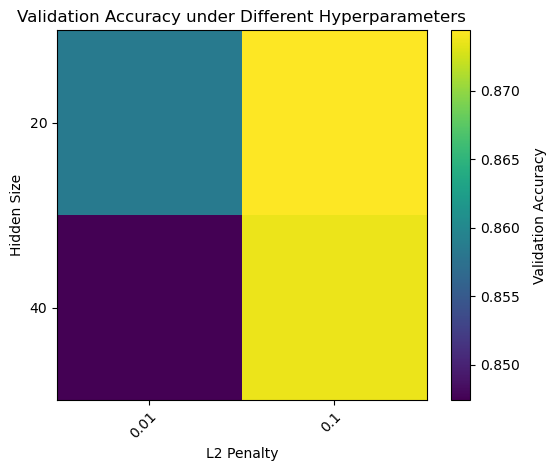

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot performance under different hyperparameters as a heatmap
def plot_results_heatmap(results):
    lr_values = sorted(set(result['lr'] for result in results))
    hidden_sizes = sorted(set(result['hidden_size'] for result in results))
    l2_values = sorted(set(result['l2_penalty'] for result in results))

    accuracies = np.zeros((len(hidden_sizes), len(l2_values)))

    for i, hidden_size in enumerate(hidden_sizes):
        for j, l2_penalty in enumerate(l2_values):
            validation_accuracy = [result['validation_accuracy'] for result in results if result['hidden_size'] == hidden_size and result['l2_penalty'] == l2_penalty]
            accuracies[i, j] = max(validation_accuracy, default=np.nan)

    fig, ax = plt.subplots()
    im = ax.imshow(accuracies, cmap='viridis')

    # Set ticks and labels
    ax.set_xticks(np.arange(len(l2_values)))
    ax.set_yticks(np.arange(len(hidden_sizes)))
    ax.set_xticklabels([f"{l2}" for l2 in l2_values])
    ax.set_yticklabels([f"{hidden}" for hidden in hidden_sizes])

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Set labels
    ax.set_xlabel('L2 Penalty')
    ax.set_ylabel('Hidden Size')
    ax.set_title('Validation Accuracy under Different Hyperparameters')

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.set_label('Validation Accuracy', rotation=90, labelpad=10)

    plt.show()

plot_results_heatmap(results)


In [27]:
# Find the hyperparameters with the highest test accuracy
best_result = max(results, key=lambda x: x['validation_accuracy'])
print("Best Hyperparameters:")
print(f"Learning Rate: {best_result['lr']}")
print(f"Hidden Layer Size: {best_result['hidden_size']}")
print(f"L2 Penalty: {best_result['l2_penalty']}")
print(f"Test Accuracy: {best_result['validation_accuracy']}")


Best Hyperparameters:
Learning Rate: 0.1
Hidden Layer Size: 20
L2 Penalty: 0.1
Test Accuracy: 0.8744166666666666


In [34]:
# Get the best hyperparameters
best_lr = best_result['lr']
best_hidden_size = best_result['hidden_size']
best_l2_penalty = best_result['l2_penalty']

# Train with metrics
train_losses, train_accuracies, test_losses, test_accuracies = train_with_metrics((train_images, train_labels), train_labels, (test_images, test_labels), test_labels, epochs=1000, batch_size=256, lr=best_lr, l2_penalty=best_l2_penalty, save_path="final_model_params.npz")

Epoch: 0/1000
Training Loss: 1184.8260191509175
Training Accuracy: 0.09670833333333333
Test Loss: 1184.8251749311314
Test Accuracy: 0.097
----------------------------------------
Epoch: 50/1000
Training Loss: 565.4964480852935
Training Accuracy: 0.7105
Test Loss: 565.5197588873831
Test Accuracy: 0.701
----------------------------------------
Epoch: 100/1000
Training Loss: 271.5991872837179
Training Accuracy: 0.8152708333333333
Test Loss: 271.64487503746574
Test Accuracy: 0.7998
----------------------------------------
Epoch: 150/1000
Training Loss: 132.28323568518962
Training Accuracy: 0.8590833333333333
Test Loss: 132.34400733126915
Test Accuracy: 0.84
----------------------------------------
Epoch: 200/1000
Training Loss: 66.89639085362357
Training Accuracy: 0.8772083333333334
Test Loss: 66.9798114936924
Test Accuracy: 0.8541
----------------------------------------
Epoch: 250/1000
Training Loss: 37.14740661282011
Training Accuracy: 0.89525
Test Loss: 37.25880629147465
Test Accuracy:

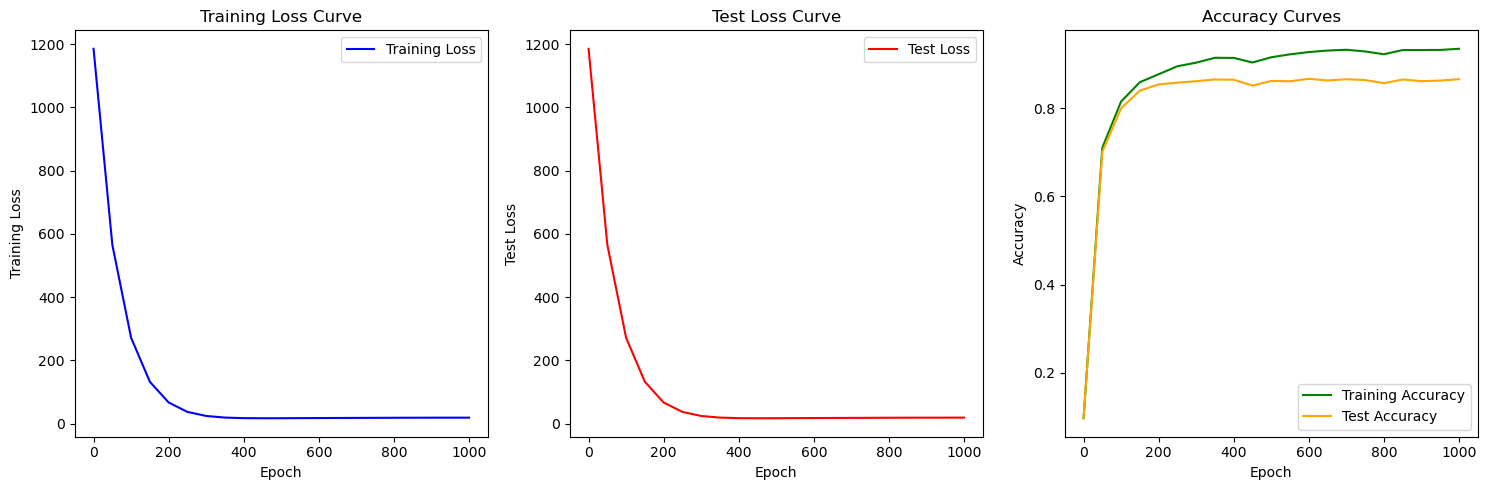

In [44]:
# Define the interval between each epoch tick
epoch_interval = 50

# Generate the adjusted epoch range for x-axis ticks
epochs_adjusted = [i * epoch_interval for i in range(len(train_losses))]

# Create a figure and subplots with appropriate spacing
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=False, sharey=False)

# Subplot for training loss
axes[0].plot(epochs_adjusted, train_losses, label='Training Loss', color='blue')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss Curve')
axes[0].legend()

# Subplot for test loss
axes[1].plot(epochs_adjusted, test_losses, label='Test Loss', color='red')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Test Loss')
axes[1].set_title('Test Loss Curve')
axes[1].legend()

# Subplot for accuracy curves
axes[2].plot(epochs_adjusted, train_accuracies, label='Training Accuracy', color='green')
axes[2].plot(epochs_adjusted, test_accuracies, label='Test Accuracy', color='orange')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy')
axes[2].set_title('Accuracy Curves')
axes[2].legend()

# Adjust layout and spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [48]:
# Load the parameters from the saved file
saved_params = np.load("final_model_params.npz")

# Extract the parameters from the saved file
final_params = {
    'w1': saved_params['w1'],
    'b1': saved_params['b1'],
    'w2': saved_params['w2'],
    'b2': saved_params['b2'],
    'w3': saved_params['w3'],
    'b3': saved_params['b3']
}

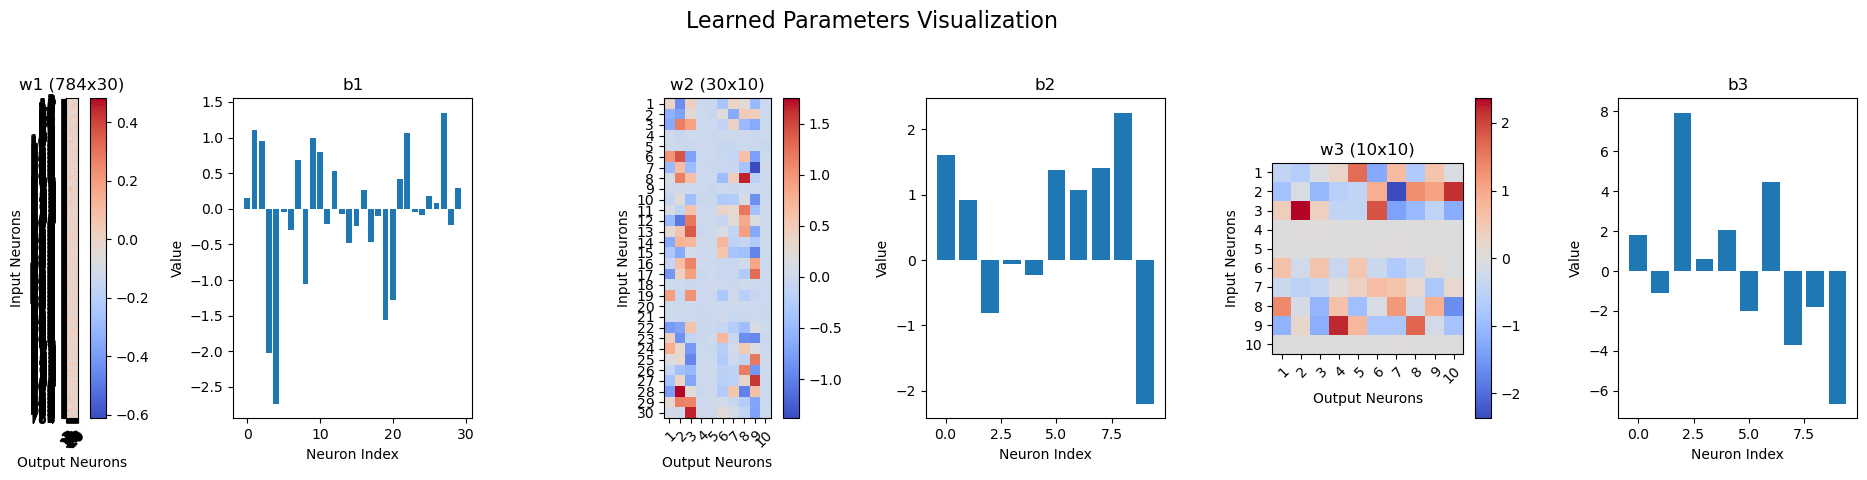

In [56]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_parameters(params):
    fig, axes = plt.subplots(1, len(params), figsize=(20, 5))
    fig.suptitle('Learned Parameters Visualization', fontsize=16)
    
    for i, (param_name, param_value) in enumerate(params.items()):
        ax = axes[i]
        if 'w' in param_name:  # Visualize weights only
            ax.imshow(param_value, cmap='coolwarm', aspect='auto')
            ax.set_title(f'{param_name} ({param_value.shape[0]}x{param_value.shape[1]})')
            ax.set_xlabel('Output Neurons')
            ax.set_ylabel('Input Neurons')
            ax.set_xticks(np.arange(param_value.shape[1]))
            ax.set_yticks(np.arange(param_value.shape[0]))
            ax.set_xticklabels(np.arange(1, param_value.shape[1] + 1))
            ax.set_yticklabels(np.arange(1, param_value.shape[0] + 1))
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
            plt.colorbar(ax.imshow(param_value, cmap='coolwarm'), ax=ax)
        else:
            # Plot biases directly
            ax.bar(range(len(param_value)), param_value)
            ax.set_title(f'{param_name}')
            ax.set_ylabel('Value')
            ax.set_xlabel('Neuron Index')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Assuming final_params contains the learned parameters of your model
visualize_parameters(final_params)
